## California Housing Price
- predict median price per district
- model: regression/labeled supervised learning
- dataset: https://github.com/ageron/handson-ml2/tree/master/datasets/housing

### 1. Read Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

In [2]:
df=pd.read_csv("california_housing.csv")
df["median_house_value"]/= 1000 #scaling
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452.6,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358.5,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352.1,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341.3,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342.2,NEAR BAY


In [3]:
df.shape

(20640, 10)

In [4]:
df.isna().sum()
#total_badrooms 207/20640 is missing

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df=df.dropna()
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### 2. Data Exploration

In [6]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206.864413
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115.435667
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14.999000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119.500000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179.700000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264.700000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500.001000


#### Take away:
- comparing to 75%, max for `total_rooms`, `population`, `households` need a further check.
- abnormal data for target col `median_house_value`.

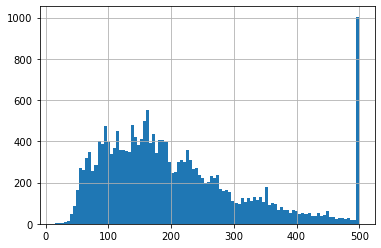

In [7]:
df.median_house_value.hist(bins=100)
#abnormal data here, outlier

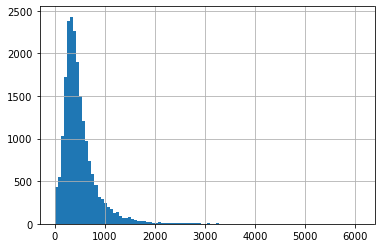

In [8]:
df.households.hist(bins=100)

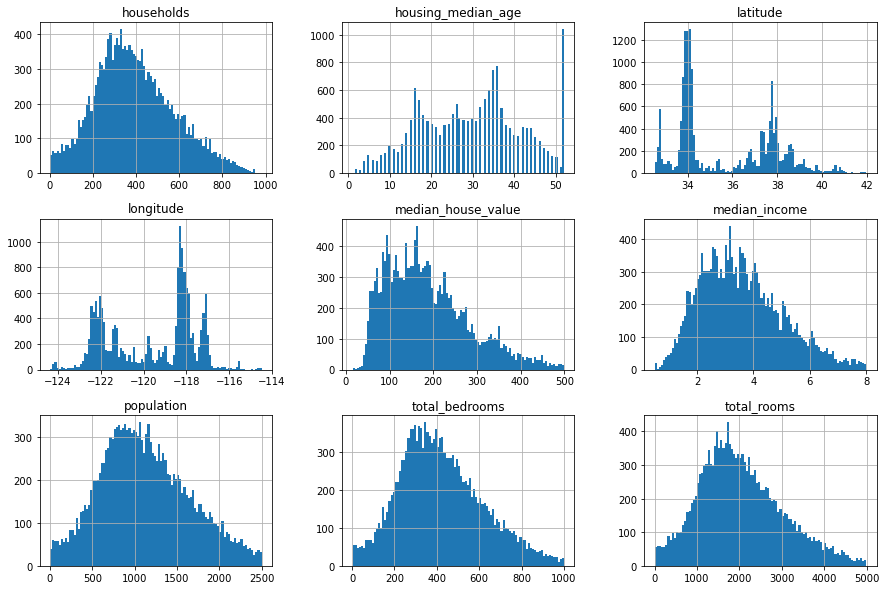

In [9]:
df=df[(df.total_rooms<=5000)&(df.total_bedrooms<=1000)&(df.population<=2500)&(df.households<=1000)&
      (df.median_income<=8)&(df.median_house_value<500)]

#df.median_house_value.hist(bins=100)
#df.total_bedrooms.hist(bins=100)
#df.median_income.hist(bins=100)
#df.total_rooms.hist(bins=100)
#df.population.hist(bins=100)
#df.households.hist(bins=100)
df.hist(bins=100,figsize=(15,10))
plt.show()

In [10]:
df.shape

(16573, 10)

In [11]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352.1,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341.3,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342.2,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269.7,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299.2,NEAR BAY


### 3. Feature Engineering

In [12]:
feature_column = []

latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")
feature_column.append(latitude)
feature_column.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become part of the model. 
fp_feature_layer = layers.DenseFeatures(feature_column)

### 4. Modeling

### 4.0 Train/Test Split

In [18]:
from sklearn.model_selection import train_test_split
train_df, test_df= train_test_split(df,test_size=0.22, random_state=123)
print("Total df size: %i\n train_df size: %i \n test_df size: %i"\
%(df.shape[0],train_df.shape[0],test_df.shape[0]))

Total df size: 16573
 train_df size: 12926 
 test_df size: 3647


### 4.1 Define functions that build and train a model
- build_model(learning_rate), which builds a randomly-initialized model.
- train_model(model, feature, label, epochs), which trains the model from the examples (feature and label) you pass.

In [19]:
#Define the functions that build and train a model
def build_model(my_learning_rate, feature_layer):
  # Create and compile a simple linear regression model.
  model = tf.keras.models.Sequential() # Most simple tf.keras models are sequential.

  # Describe the topography of the model.
  model.add(feature_layer)
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,))) #a single node in a single layer.

  # Compile into TensorFlow. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        

#Train the model by feeding feature and label.
def train_model(model, df, epochs, batch_size, label_name):
    
  features = {name:np.array(value) for name, value in df.items()}
  label = np.array(features.pop(label_name))
    
  history = model.fit(x=featurs,y=label,
                      batch_size=batch_size,epochs=epochs,
                      shuffle=True) # specified number of epochs. 

  # Gather the trained model's weight and bias.
  #trained_weight = model.get_weights()[0]
  #trained_bias = model.get_weights()[1]

  epochs = history.epoch # The list of epochs is stored separately from the rest of history.
  
  hist = pd.DataFrame(history.history) # Isolate the error for each epoch.
  rmse = hist["root_mean_squared_error"] # Take a snapshot of the model's root mean squared error at each epoch. 

  return epochs, rmse

### 4.2 Define plotting functions
- a loss curve

In [20]:
#Plot a curve of loss vs. epoch.
def plot_the_loss_curve(epochs, rmse):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()  

### 4.3 Call the model functions

In [16]:
# Hyperparameters:
learning_rate = 0.05
epochs = 30
batch_size = 100

label_name="median_house_value" 

# Discard any pre-existing version of the model.
my_model = None 

# Invoke the functions.
my_model = build_model(learning_rate，fp_feature_layer)
epochs, rmse = train_model(my_model, train_df,
                           epochs, batch_size,label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

SyntaxError: invalid character in identifier (<ipython-input-16-866de06d95d8>, line 12)

### 4.4 Make predictions

In [ ]:
def predict_house_values(n, feature, label):

  batch = train[feature][10000:10000 + n]
  y_predicted= my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (train[feature][10000 + i],
                                   train[label][10000 + i],
                                   y_predicted[i][0] ))

In [ ]:
# invoke the prediction function on 10 examples:
predict_house_values(4, my_feature, my_label)

In [ ]:
# why it stuck at 4 examples?
# features now is one: room_size, how to scale to all features?